## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Simulating the random walk

### Start of the random walk

In [2]:
def start(x, y, n_ants=5):
    
    """Inputs: starting point (x,y) and the number of ants in the simulation.
       Outputs: starting array and the number of ants."""
    
    start_arr = np.repeat(np.array([[x, y]]), n_ants, axis=0)
    
    return start_arr, n_ants

### Boundary functions

In [3]:
def boundary_1(arr):
    
    """Inputs: an array of shape (N, 2).
       Outputs: True if a point is outside the boundary condition."""
    
    condition = ((np.abs(arr[:, 0]) >= 2) | (np.abs(arr[:, 1]) >= 2))
    
    return condition

In [4]:
def boundary_2(arr):
    
    """Inputs: an array of shape (N, 2).
       Outputs: True if a point is outside the boundary condition."""
    
    condition = (arr[:, 0] + arr[:, 1] >= 1)
    
    return condition

In [5]:
def boundary_3(arr):
    
    """Inputs: an array of shape (N, 2).
       Outputs: True if a point is outside the boundary condition."""
    
    condition = (((arr[:, 0] - 0.25) / 3)**2 + ((arr[:, 1] - 0.25) / 4)**2 >= 1)
    
    return condition

### Random walk simulation

In [6]:
def random_walk(start_arr, boundary=boundary_1):
    
    """Inputs: the starting array and boundary.
       Outputs the time that every and took to get to the boundary."""
    
    poss = np.array([[-1, 0],
                     [0, -1], 
                     [1, 0], 
                     [0, 1]])
    
    walk_arr, n_ants = start_arr
    
    times = np.zeros((walk_arr.shape[0], 1), dtype=np.int32)
    
    while (~np.all(np.any(np.isnan(walk_arr), axis=1))):
                
        choice = np.random.choice([0, 1, 2, 3], n_ants)
        walk_arr += poss[choice]
        
        walk_arr = np.where(boundary(walk_arr).reshape(-1, 1), np.nan, walk_arr)
        
        times += 1 * (~np.any(np.isnan(walk_arr), axis=1).reshape(-1, 1))
        
    return times + 1

### Question 1

In [7]:
start_walk = start(0, 0, n_ants=100000)
times_to_plot = random_walk(start_walk, boundary=boundary_1)

It seems that it takes around 4.5 seconds to reach the square.

In [8]:
np.mean(times_to_plot)

4.4973

### Question 2

In [9]:
start_walk = start(0, 0, n_ants=10)
times_to_plot = random_walk(start_walk, boundary=boundary_2)

After a couple of experiments with the ant number, it seems this result diverges.

In [10]:
np.mean(times_to_plot)

36.4

### Question 3

In [11]:
start_walk = start(0, 0, n_ants=100000)
times_to_plot = random_walk(start_walk, boundary=boundary_3)

It seems that it takes around 14 seconds to reach the ellipse.

In [12]:
np.mean(times_to_plot)

13.94562

### Plot of Q3

We note the curious relation between even and odd number of steps. A brute force calculation would show that there are two series to compute this result.

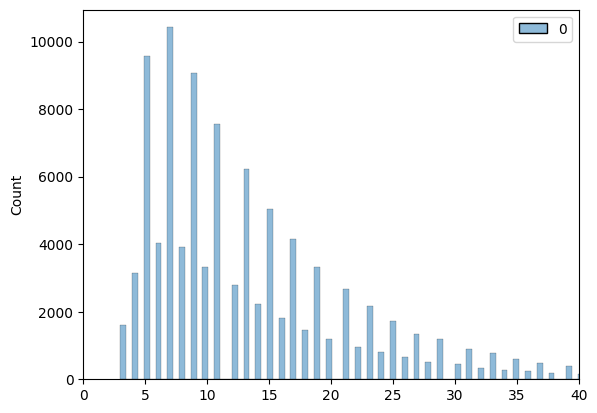

In [13]:
sns.histplot(times_to_plot)
plt.xlim(0,40)
plt.show()

## Exact answer using Markov chains

In [14]:
def get_arr_inside_boundary(range_len=(-20, 20), boundary=boundary_3):
    
    """We output the points inside the boundary."""
    
    # Choose at least all points around the boundary
    x = np.arange(*range_len)
    y = np.arange(*range_len)
    
    # Total grid you chose
    arr_total = np.dstack(np.meshgrid(x, y)).reshape(-1, 2)
    
    # Grid inside the boundary
    arr_inside = arr_total[~boundary(arr_total)]
    
    return arr_inside

In [15]:
def plot_points_boundary(arr_inside):
    
    """Plotting function."""
    
    # Define the movements of each point inside the boundary.
    test_arr_1 = arr_inside + np.array([[-1, 0]])
    test_arr_2 = arr_inside + np.array([[1, 0]])
    test_arr_3 = arr_inside + np.array([[0, -1]])
    test_arr_4 = arr_inside + np.array([[0, 1]])
    
    # We use a mask to check whether they are still inside or not.
    mask_1 = (test_arr_1[:, None] == arr_inside).all(-1).any(1)
    mask_2 = (test_arr_2[:, None] == arr_inside).all(-1).any(1)
    mask_3 = (test_arr_3[:, None] == arr_inside).all(-1).any(1)
    mask_4 = (test_arr_4[:, None] == arr_inside).all(-1).any(1)
    
    # We count the number of times the movement left a particular point still inside.
    prob_count = (mask_1).astype(np.int8) + \
                 (mask_2).astype(np.int8) + \
                 (mask_3).astype(np.int8) + \
                 (mask_4).astype(np.int8)
    
    # We plot the points.
    plt.scatter(arr_inside[prob_count == 2][:, 0], arr_inside[prob_count == 2][:, 1],
                color='b', marker='x', label='2 transitions')
    plt.scatter(arr_inside[prob_count == 3][:, 0], arr_inside[prob_count == 3][:, 1],
                color='g', marker='^', label='3 transitions')
    plt.scatter(arr_inside[prob_count == 4][:, 0], arr_inside[prob_count == 4][:, 1],
                color='c', marker='o', label='4 transitions')
    plt.xlim(arr_inside.min() - 1, arr_inside.max() + 1)
    plt.ylim(arr_inside.min() - 1, arr_inside.max() + 1)
    plt.legend()
    plt.show()
    
    return

In [16]:
def get_transition(arr_inside):
    
    """We compute the transition matrix for this Markov process with absorbing states."""
    
    # Define the movements of each point inside the boundary.
    test_arr_1 = arr_inside + np.array([[-1, 0]])
    test_arr_2 = arr_inside + np.array([[1, 0]])
    test_arr_3 = arr_inside + np.array([[0, -1]])
    test_arr_4 = arr_inside + np.array([[0, 1]])
    
    # Define inside points as a list and initialize parameters.
    true_lst = arr_inside.tolist()
    size_space = len(true_lst)
    transition_matrix = np.zeros((size_space, size_space))
    
    # For each state after a movement, we ask the index of the final state within the list if it is still inside.
    # We build the transition matrix from the initial and final indices.
    # Example:
    # (0,0) has index i and it goes (0,0) -> (1, 0). The state (1, 0) is inside. 
    # Then, we get the index j of (1,0). We populate with a 1 the transition matrix in the entry (i,j).
    for k in range(size_space):
        test_elem_lst_1 = test_arr_1[k].tolist()
        test_elem_lst_2 = test_arr_2[k].tolist()
        test_elem_lst_3 = test_arr_3[k].tolist()
        test_elem_lst_4 = test_arr_4[k].tolist()
        
        if test_elem_lst_1 in true_lst:
            transition_matrix[k, true_lst.index(test_elem_lst_1)] = 1
        if test_elem_lst_2 in true_lst:
            transition_matrix[k, true_lst.index(test_elem_lst_2)] = 1
        if test_elem_lst_3 in true_lst:
            transition_matrix[k, true_lst.index(test_elem_lst_3)] = 1
        if test_elem_lst_4 in true_lst:
            transition_matrix[k, true_lst.index(test_elem_lst_4)] = 1
            
    return transition_matrix / 4

### Question 1

We get the states inside the square.

In [17]:
arr_inside = get_arr_inside_boundary(boundary=boundary_1)

We plot these states.

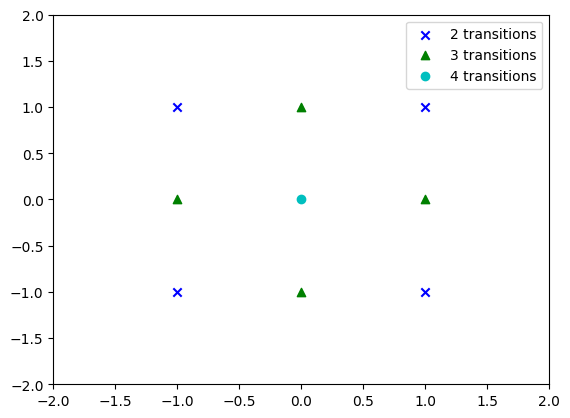

In [18]:
plot_points_boundary(arr_inside)

We compute the transition matrix $Q$.

In [19]:
Q = get_transition(arr_inside)

We compute $(I - Q)^{-1} \mathbf{1}$ which gives the vector of expected steps from every state until we reach an absorbing state, i.e. the boundary.

In [20]:
expexted_steps = (np.linalg.inv(np.eye(Q.shape[0]) - Q) @ np.ones((Q.shape[0], 1)))

We get the index of the state $(0,0)$.

In [21]:
index_origin = arr_inside.tolist().index([0,0])

We compute the expected number of steps for a given boundary. We can see that for the ellipse, the expected number of steps from the origin is $\mathbb{E}\left[S_{(0,0)} \, \right] = 4.5$.

In [22]:
expexted_steps[index_origin]

array([4.5])

### Question 3

We get the states inside the ellipse.

In [23]:
arr_inside = get_arr_inside_boundary(boundary=boundary_3)

We plot these states.

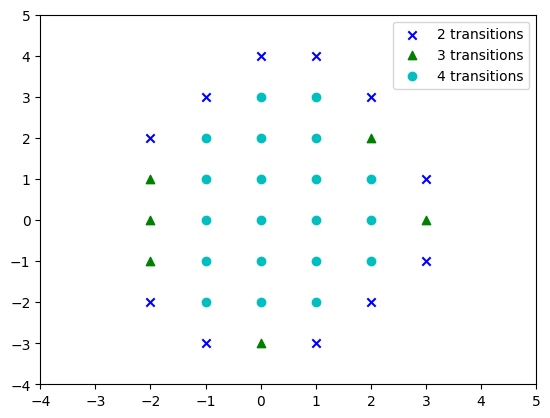

In [24]:
plot_points_boundary(arr_inside)

We compute the transition matrix $Q$.

In [25]:
Q = get_transition(arr_inside)

We compute $(I - Q)^{-1} \mathbf{1}$ which gives the vector of expected steps from every state until we reach an absorbing state, i.e. the boundary.

In [26]:
expexted_steps = (np.linalg.inv(np.eye(Q.shape[0]) - Q) @ np.ones((Q.shape[0], 1)))

We get the index of the state $(0,0)$.

In [27]:
index_origin = arr_inside.tolist().index([0,0])

We compute the expected number of steps for a given boundary. We can see that for the ellipse, the expected number of steps from the origin is $\mathbb{E}\left[S_{(0,0)} \, \right] \approx 13.992$ and not $14$.

In [28]:
expexted_steps[index_origin]

array([13.99205306])

### What about Question 2?

Our calculation cannot be done with an unbounded space such as with the case of Q2.

We first transform this problem into a 1D random walk. By using the fact that $x+y = 1$ is the boundary, we can collapse this system into a problem of the new variable $z = x + y$, and the boundary is $z = 1$.

Then, the expected number of steps from the origin to the boundary is given by the relation $\mathbb{E}\left[S_{0} \, \right] = 1 + (1-p) \times \mathbb{E}\left[S_{1} \, \right] + p \times \mathbb{E}\left[S_{-1} \, \right]$, where $p$ is the probability of making a step to the left and the $1$ is a single step before it starts the chain from another state. We also note that $\mathbb{E}\left[S_{1} \, \right] = 0$ because we already reached the boundary.

Given that from $z=-1$ we neet to take twice the distance to get to the boundary, then, $\mathbb{E}\left[S_{-1} \, \right] = 2 \mathbb{E}\left[S_{0} \, \right]$.

As such, we get the relation $\mathbb{E}\left[S_{0} \, \right] = \frac{1}{1 - 2p}$, which diverges for $p = \frac{1}{2}$. Thus, the solution is that the number of expected steps is infinite.